# 05 - Classificando patologias em toras usando combinação de `OTSU_treshold + LBP + SVM` e normalizando amostras pela dimensão da imagem (quantidade de píxels)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'broca': 0,
                'fissura': 1,
                'musgo': 2,
                'quebra': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)

    img_ostu = img >= threshold_otsu(img)
    
    lbp = local_binary_pattern(image=img_ostu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pela quantidade de píxeis
    arr /= np.product(img.shape)

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_norm1_toras.csv')
data

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.001429,0.002942,0.0,0.000420,0.0,0.002354,0.0,0.000841,0.0,0.0,...,0.0,0.004792,0.0,0.003867,0.0,0.003699,0.0,0.864901,0.011938,0
1,0.002078,0.003097,0.0,0.001209,0.0,0.003060,0.0,0.001209,0.0,0.0,...,0.0,0.005099,0.0,0.003777,0.0,0.004155,0.0,0.839730,0.022362,0
2,0.000271,0.000698,0.0,0.000581,0.0,0.000736,0.0,0.000388,0.0,0.0,...,0.0,0.003100,0.0,0.004921,0.0,0.005154,0.0,0.907037,0.005735,0
3,0.000026,0.000026,0.0,0.000142,0.0,0.000013,0.0,0.000103,0.0,0.0,...,0.0,0.001317,0.0,0.002285,0.0,0.001768,0.0,0.939486,0.000723,0
4,0.002204,0.004034,0.0,0.002577,0.0,0.004183,0.0,0.002913,0.0,0.0,...,0.0,0.007432,0.0,0.009113,0.0,0.008105,0.0,0.784725,0.030177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.000364,0.001604,0.0,0.001166,0.0,0.001895,0.0,0.000948,0.0,0.0,...,0.0,0.006414,0.0,0.004446,0.0,0.008820,0.0,0.817479,0.015234,3
1188,0.001433,0.003614,0.0,0.001869,0.0,0.003676,0.0,0.001558,0.0,0.0,...,0.0,0.004860,0.0,0.001932,0.0,0.003614,0.0,0.832004,0.031717,3
1189,0.000836,0.001150,0.0,0.001672,0.0,0.001463,0.0,0.001150,0.0,0.0,...,0.0,0.010347,0.0,0.005226,0.0,0.006689,0.0,0.826819,0.013273,3
1190,0.001984,0.004850,0.0,0.002866,0.0,0.005181,0.0,0.001433,0.0,0.0,...,0.0,0.007055,0.0,0.005511,0.0,0.007606,0.0,0.766865,0.046076,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 7396
              precision    recall  f1-score   support

       broca       0.97      0.86      0.91        86
     fissura       0.88      0.98      0.93        91
       musgo       0.94      1.00      0.97        92
      quebra       1.00      0.93      0.97        89

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.95      0.94      0.94       358



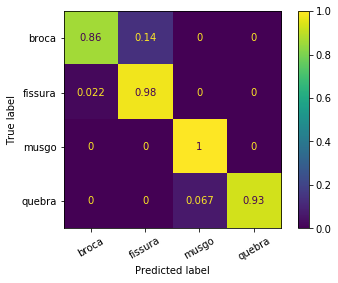

Rodada 1	-	Seed 5767
              precision    recall  f1-score   support

       broca       0.99      0.87      0.92        91
     fissura       0.88      0.99      0.93        85
       musgo       0.96      0.97      0.96        90
      quebra       0.98      0.97      0.97        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



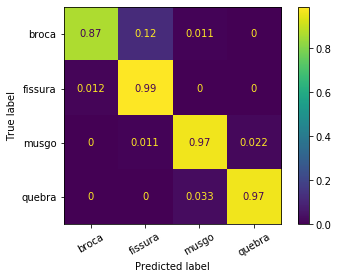

Rodada 2	-	Seed 4884
              precision    recall  f1-score   support

       broca       0.99      0.89      0.94       101
     fissura       0.87      0.95      0.91        85
       musgo       0.90      0.98      0.94        90
      quebra       0.97      0.90      0.94        82

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



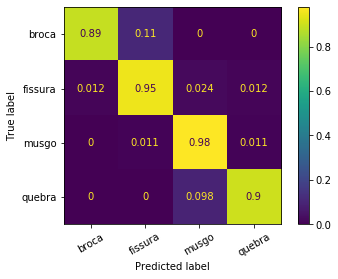

Rodada 3	-	Seed 7635
              precision    recall  f1-score   support

       broca       0.97      0.91      0.94        97
     fissura       0.90      0.97      0.93        87
       musgo       0.94      0.97      0.95        75
      quebra       0.98      0.95      0.96        99

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



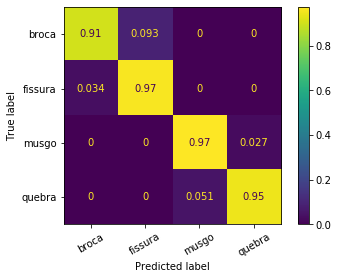

Rodada 4	-	Seed 6504
              precision    recall  f1-score   support

       broca       0.99      0.96      0.97        91
     fissura       0.97      0.99      0.98        87
       musgo       0.96      0.97      0.96        88
      quebra       0.97      0.97      0.97        92

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



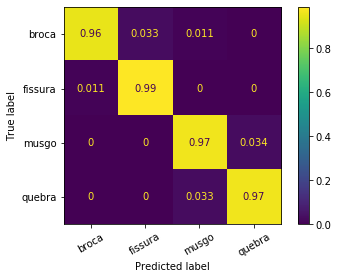

Rodada 5	-	Seed 3715
              precision    recall  f1-score   support

       broca       0.96      0.88      0.92        80
     fissura       0.91      0.96      0.93        92
       musgo       0.97      1.00      0.98        91
      quebra       0.98      0.97      0.97        95

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



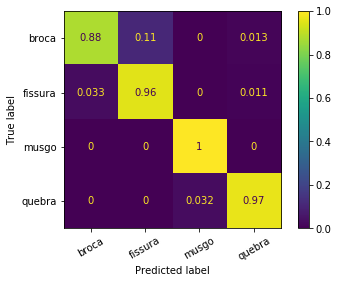

Rodada 6	-	Seed 7926
              precision    recall  f1-score   support

       broca       0.99      0.90      0.94        86
     fissura       0.91      0.99      0.94        78
       musgo       0.92      0.98      0.95       100
      quebra       0.98      0.93      0.95        94

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



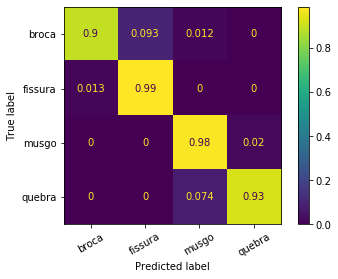

Rodada 7	-	Seed 1128
              precision    recall  f1-score   support

       broca       0.95      0.91      0.93        96
     fissura       0.90      0.89      0.90        91
       musgo       0.92      0.98      0.95        88
      quebra       0.95      0.95      0.95        83

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



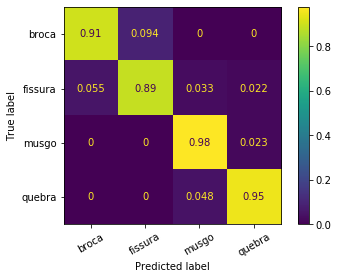

Rodada 8	-	Seed 7330
              precision    recall  f1-score   support

       broca       0.95      0.87      0.91        92
     fissura       0.86      0.94      0.90        81
       musgo       0.95      0.96      0.95        94
      quebra       0.95      0.95      0.95        91

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



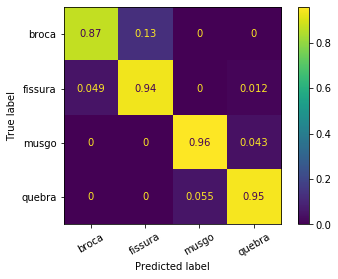

Rodada 9	-	Seed 5855
              precision    recall  f1-score   support

       broca       0.97      0.93      0.95        95
     fissura       0.92      0.96      0.94        89
       musgo       0.96      0.98      0.97        90
      quebra       0.98      0.96      0.97        84

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



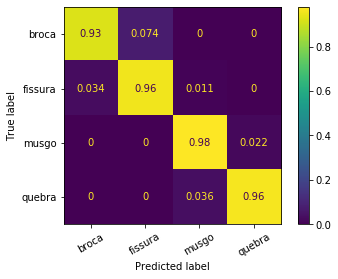

Rodada 10	-	Seed 4002
              precision    recall  f1-score   support

       broca       0.99      0.88      0.93        95
     fissura       0.90      0.98      0.94        92
       musgo       0.92      1.00      0.96        83
      quebra       0.99      0.93      0.96        88

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



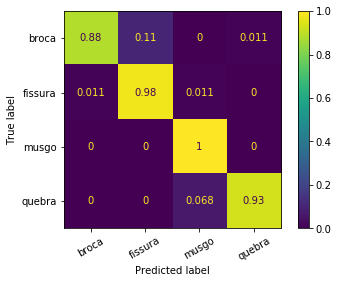

Rodada 11	-	Seed 6987
              precision    recall  f1-score   support

       broca       0.98      0.94      0.96        86
     fissura       0.93      0.96      0.94        89
       musgo       0.93      0.96      0.95       104
      quebra       0.95      0.92      0.94        79

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



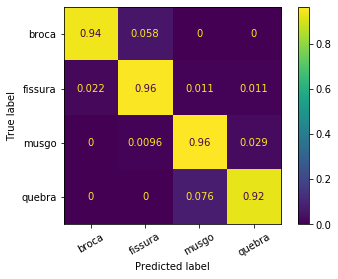

Rodada 12	-	Seed 6602
              precision    recall  f1-score   support

       broca       0.97      0.88      0.92        82
     fissura       0.90      0.98      0.93        88
       musgo       0.97      0.99      0.98        90
      quebra       0.99      0.97      0.98        98

    accuracy                           0.96       358
   macro avg       0.96      0.95      0.95       358
weighted avg       0.96      0.96      0.96       358



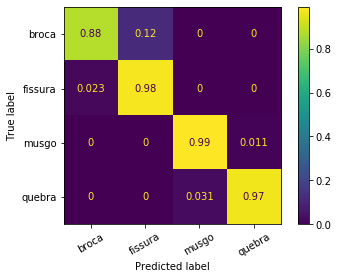

Rodada 13	-	Seed 7791
              precision    recall  f1-score   support

       broca       0.98      0.84      0.90       104
     fissura       0.82      0.97      0.89        77
       musgo       0.93      0.99      0.96        97
      quebra       0.99      0.91      0.95        80

    accuracy                           0.92       358
   macro avg       0.93      0.93      0.92       358
weighted avg       0.93      0.92      0.92       358



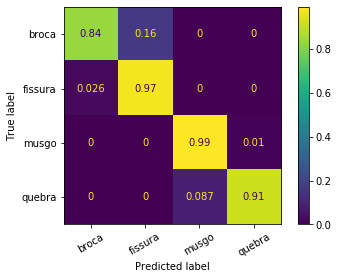

Rodada 14	-	Seed 371
              precision    recall  f1-score   support

       broca       0.97      0.88      0.92       102
     fissura       0.89      0.97      0.93        97
       musgo       0.93      0.98      0.95        85
      quebra       0.99      0.93      0.96        74

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



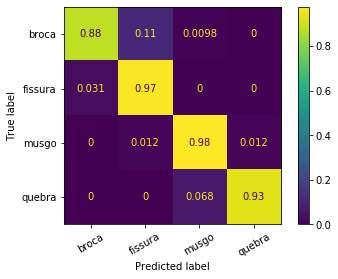

Rodada 15	-	Seed 4891
              precision    recall  f1-score   support

       broca       0.94      0.88      0.91        86
     fissura       0.90      0.90      0.90        90
       musgo       0.92      0.95      0.94        84
      quebra       0.93      0.95      0.94        98

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



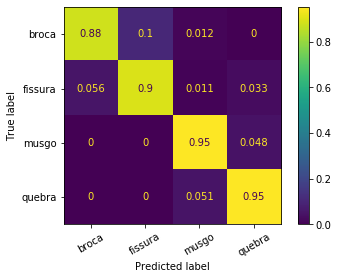

Rodada 16	-	Seed 2388
              precision    recall  f1-score   support

       broca       0.97      0.86      0.91        87
     fissura       0.86      0.95      0.90        88
       musgo       0.93      0.98      0.95        81
      quebra       0.99      0.95      0.97       102

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.93       358
weighted avg       0.94      0.94      0.94       358



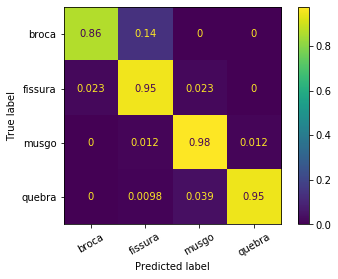

Rodada 17	-	Seed 241
              precision    recall  f1-score   support

       broca       0.97      0.89      0.93        99
     fissura       0.88      0.96      0.92        77
       musgo       0.97      0.96      0.96        90
      quebra       0.95      0.97      0.96        92

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



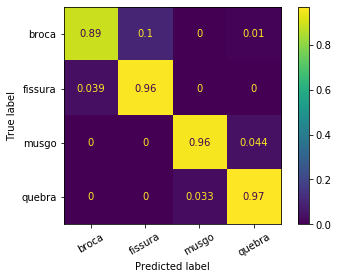

Rodada 18	-	Seed 7116
              precision    recall  f1-score   support

       broca       0.96      0.91      0.94        89
     fissura       0.92      0.94      0.93       104
       musgo       0.93      0.99      0.96        81
      quebra       0.96      0.94      0.95        84

    accuracy                           0.94       358
   macro avg       0.95      0.95      0.94       358
weighted avg       0.94      0.94      0.94       358



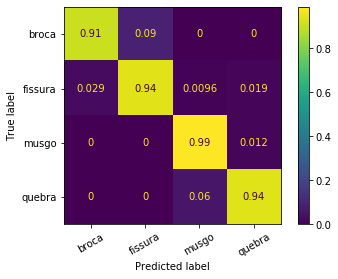

Rodada 19	-	Seed 7478
              precision    recall  f1-score   support

       broca       0.97      0.95      0.96        88
     fissura       0.95      0.96      0.95        90
       musgo       0.98      0.93      0.95       100
      quebra       0.93      0.99      0.96        80

    accuracy                           0.96       358
   macro avg       0.95      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



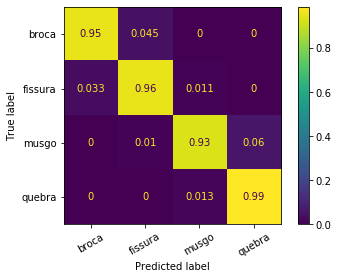

Rodada 20	-	Seed 4905
              precision    recall  f1-score   support

       broca       0.99      0.90      0.94        87
     fissura       0.91      0.98      0.94        88
       musgo       0.92      0.97      0.94        93
      quebra       0.95      0.91      0.93        90

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



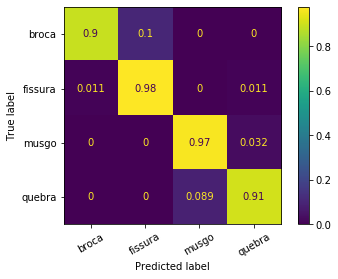

Rodada 21	-	Seed 1374
              precision    recall  f1-score   support

       broca       0.92      0.91      0.91        76
     fissura       0.94      0.90      0.92       102
       musgo       0.92      0.98      0.95        82
      quebra       0.96      0.96      0.96        98

    accuracy                           0.94       358
   macro avg       0.93      0.94      0.93       358
weighted avg       0.94      0.94      0.94       358



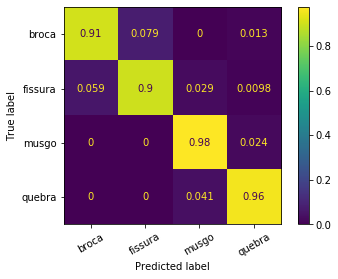

Rodada 22	-	Seed 615
              precision    recall  f1-score   support

       broca       0.97      0.90      0.93        92
     fissura       0.90      0.94      0.92        87
       musgo       0.94      0.99      0.97        86
      quebra       0.98      0.96      0.97        93

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



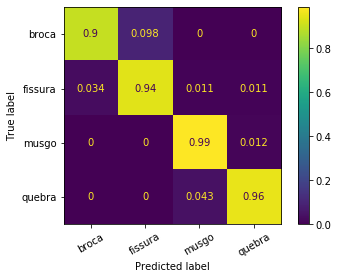

Rodada 23	-	Seed 4770
              precision    recall  f1-score   support

       broca       0.95      0.92      0.94        89
     fissura       0.90      0.95      0.93        80
       musgo       0.97      0.97      0.97        98
      quebra       0.98      0.97      0.97        91

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



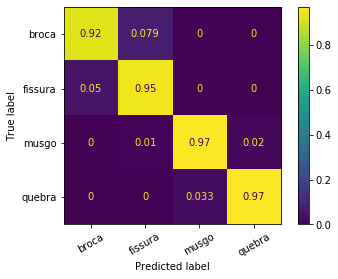

Rodada 24	-	Seed 3333
              precision    recall  f1-score   support

       broca       0.97      0.93      0.95        81
     fissura       0.95      0.96      0.95        95
       musgo       0.92      0.99      0.95        92
      quebra       0.98      0.93      0.95        90

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



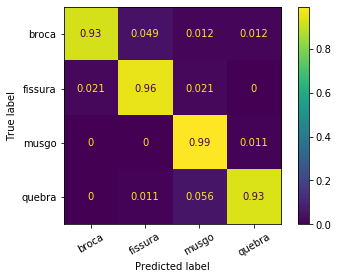

Rodada 25	-	Seed 6621
              precision    recall  f1-score   support

       broca       0.96      0.87      0.91       103
     fissura       0.84      0.93      0.88        80
       musgo       0.95      0.99      0.97        88
      quebra       0.99      0.95      0.97        87

    accuracy                           0.93       358
   macro avg       0.93      0.94      0.93       358
weighted avg       0.94      0.93      0.93       358



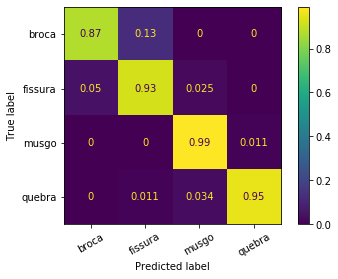

Rodada 26	-	Seed 4137
              precision    recall  f1-score   support

       broca       0.99      0.89      0.93        96
     fissura       0.88      0.94      0.91        79
       musgo       0.85      0.96      0.91        85
      quebra       0.97      0.91      0.94        98

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.93      0.92      0.92       358



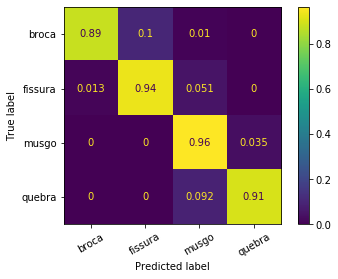

Rodada 27	-	Seed 7603
              precision    recall  f1-score   support

       broca       0.97      0.93      0.95        91
     fissura       0.93      0.96      0.95        90
       musgo       0.98      0.98      0.98        94
      quebra       0.95      0.96      0.96        83

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



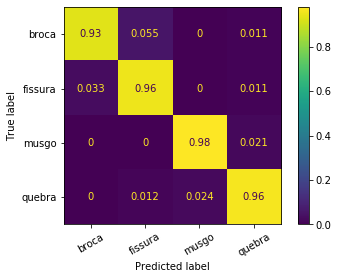

Rodada 28	-	Seed 7551
              precision    recall  f1-score   support

       broca       0.98      0.89      0.93        97
     fissura       0.91      0.98      0.94        92
       musgo       0.95      0.99      0.97        78
      quebra       0.98      0.97      0.97        91

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



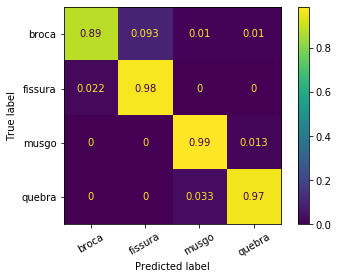

Rodada 29	-	Seed 7528
              precision    recall  f1-score   support

       broca       0.94      0.87      0.90        85
     fissura       0.90      0.95      0.93        99
       musgo       0.88      0.96      0.92        84
      quebra       0.95      0.88      0.91        90

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



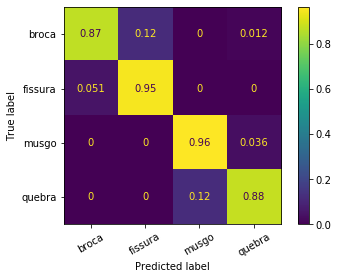

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_norm1_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

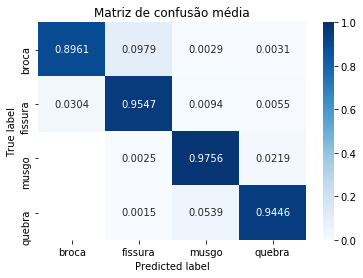

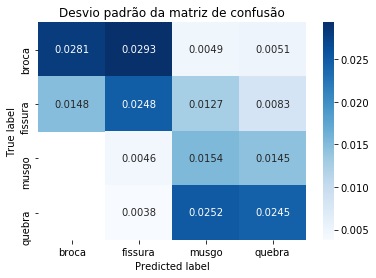

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia   f1-broca  f1-fissura   f1-musgo  f1-quebra
count  30.000000  30.000000   30.000000  30.000000  30.000000
mean    0.942272   0.930260    0.926186   0.955437   0.956348
std     0.012585   0.017349    0.021198   0.016292   0.015304
min     0.916201   0.901554    0.880952   0.906077   0.913295
25%     0.933659   0.914734    0.912398   0.950571   0.948744
50%     0.945531   0.931157    0.927630   0.956166   0.958209
75%     0.952514   0.938643    0.939725   0.966477   0.969348
max     0.969274   0.972067    0.977273   0.983784   0.979381


Acurácia,f1-broca,f1-fissura,f1-musgo,f1-quebra
0.944134,0.913580,0.927083,0.968421,0.965116
0.946927,0.923977,0.928177,0.961326,0.972678
0.930168,0.937500,0.910112,0.936170,0.936709
0.946927,0.936170,0.933333,0.954248,0.964103
0.969274,0.972067,0.977273,0.960452,0.967391
0.952514,0.915033,0.931217,0.983784,0.973545
0.946927,0.939024,0.944785,0.951456,0.950820
0.930168,0.925532,0.895028,0.950276,0.951807
0.927374,0.909091,0.899408,0.952381,0.945055
0.955307,0.946237,0.939227,0.967033,0.970060


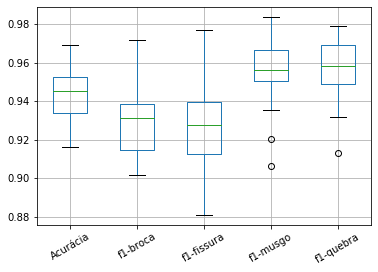

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')